# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

env: CUDA_LAUNCH_BLOCKING=1


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_78788/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_78788/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_78788/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_tes

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-25 20:22:30,280] A new study created in RDB with name: no-name-9821c14f-55ca-416e-95b4-5e3f70781515
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:618: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4514, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:02<29:05,  1.14it/s]  

current_loss_val:  1.446315050125122
current_loss: tensor(1.4514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4154671430587769
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:02<20:11,  1.65it/s]

current_loss_val:  1.4151995182037354
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4219, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:02<18:05,  1.84it/s]

current_loss_val:  1.4149839878082275
current_loss: tensor(1.4219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:03<11:13,  2.96it/s]

current_loss_val:  1.4149959087371826
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4146344661712646


  0%|          | 7/2000 [00:03<09:26,  3.52it/s]

current_loss: tensor(1.4217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4145509004592896
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<07:45,  4.28it/s]

current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4145153760910034
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:03<07:23,  4.49it/s]

current_loss_val:  1.414481282234192
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:04<06:22,  5.21it/s]

current_loss_val:  1.4144272804260254
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4142227172851562
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:04<06:00,  5.51it/s]

current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4141712188720703
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<05:36,  5.90it/s]

current_loss_val:  1.4140537977218628
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4142001867294312
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<04:55,  6.72it/s]

current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4141221046447754
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4140220880508423


  1%|          | 17/2000 [00:04<04:34,  7.22it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4140615463256836
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<04:53,  6.76it/s]

current_loss_val:  1.4140576124191284
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4140515327453613


  1%|          | 20/2000 [00:05<05:00,  6.58it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4140052795410156
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<04:52,  6.76it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4139738082885742
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4139561653137207


  1%|          | 23/2000 [00:05<04:32,  7.25it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4139280319213867
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<04:52,  6.74it/s]

current_loss_val:  1.4138599634170532
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4136039018630981


  1%|▏         | 26/2000 [00:06<05:03,  6.51it/s]

current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4135322570800781
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:06<03:38,  9.01it/s]

current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.413565993309021
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4134414196014404
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4135152101516724


  2%|▏         | 31/2000 [00:06<03:04, 10.67it/s]

current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4135156869888306
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4135545492172241
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.413550615310669


  2%|▏         | 32/2000 [00:06<06:58,  4.70it/s]


current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.41354501247406
Early Stop at iteration 32 with minimal loss tensor(1.4134, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<09:03,  3.68it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3727437257766724


  0%|          | 2/2000 [00:00<06:09,  5.41it/s]

current_loss: tensor(1.3870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3137695789337158
current_loss: tensor(1.3462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:44,  7.02it/s]

current_loss_val:  1.286688208580017
current_loss: tensor(1.3430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.290774941444397
current_loss: tensor(1.3216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3191, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:20,  7.67it/s]

current_loss_val:  1.291704535484314
current_loss: tensor(1.3191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2930798530578613
current_loss: tensor(1.3158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3139, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:20,  6.21it/s]

current_loss_val:  1.2925230264663696
current_loss: tensor(1.3139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2917284965515137
Early Stop at iteration 7 with minimal loss tensor(1.2867, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:22:44,743] Trial 0 finished with value: -2.573376178741455 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.595673385356758, 'penalty_decorrelation_ridge_second_difference': 20.396541199004588}. Best is trial 0 with value: -2.573376178741455.
  0%|          | 1/2000 [00:00<05:40,  5.88it/s]

current_loss: tensor(1.3159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2864363193511963
current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:25,  7.51it/s]

current_loss: tensor(1.3006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2856128215789795
current_loss: tensor(1.3006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2816219329833984
current_loss: 

  0%|          | 4/2000 [00:00<04:17,  7.76it/s]

tensor(1.2959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274631381034851
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:08,  8.01it/s]

current_loss_val:  1.2689404487609863
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622369527816772
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:05,  8.12it/s]

current_loss_val:  1.2511850595474243
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246744990348816
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:27,  7.45it/s]

current_loss_val:  1.2469946146011353
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469335794448853
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:17,  7.73it/s]

current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471206188201904
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475967407226562


  1%|          | 12/2000 [00:01<04:38,  7.14it/s]


current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247431755065918
Early Stop at iteration 12 with minimal loss tensor(1.2467, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:22:47,013] Trial 1 finished with value: -2.493489980697632 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5061525551488546, 'penalty_decorrelation_ridge_second_difference': 17.86022135971862}. Best is trial 1 with value: -2.493489980697632.
  0%|          | 1/2000 [00:00<05:43,  5.82it/s]

current_loss: tensor(1.3527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286978840827942
current_loss: tensor(1.3257, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:27,  7.48it/s]

current_loss: tensor(1.3227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2869592905044556
current_loss: tensor(1.3227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286704182624817
current_loss: 

  0%|          | 4/2000 [00:00<04:18,  7.73it/s]

tensor(1.3156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2856062650680542
current_loss: tensor(1.3137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:09,  8.00it/s]

current_loss_val:  1.2853455543518066
current_loss: tensor(1.3109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.284980297088623
current_loss: tensor(1.3097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:05,  8.10it/s]

current_loss_val:  1.2838115692138672
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2811506986618042
current_loss: tensor(1.3055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:04,  8.15it/s]

current_loss_val:  1.2790864706039429
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735011577606201
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:20,  7.63it/s]

current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696101665496826
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672688961029053
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:11,  7.90it/s]

current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640235424041748
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619702816009521
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:06,  8.04it/s]

current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260167121887207
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257441759109497
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:03,  8.13it/s]

current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549810409545898
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541561126708984
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:02,  8.17it/s]

current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536845207214355
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528865337371826
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<04:01,  8.18it/s]

current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523008584976196
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252091407775879
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:05,  8.05it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517027854919434
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512131929397583


  1%|▏         | 25/2000 [00:03<04:04,  8.07it/s]

current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510896921157837
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:03,  8.10it/s]

current_loss_val:  1.2509148120880127
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250311017036438
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:29,  7.33it/s]

current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501749992370605
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<04:59,  6.58it/s]

current_loss_val:  1.249432921409607
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485430240631104
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:53,  6.70it/s]

current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481751441955566
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:34,  7.18it/s]

current_loss_val:  1.24805748462677
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478443384170532
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:17,  7.63it/s]

current_loss_val:  1.2470628023147583
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464563846588135
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<04:08,  7.90it/s]

current_loss_val:  1.246161699295044
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453523874282837
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<04:04,  8.03it/s]

current_loss_val:  1.2441428899765015
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442609071731567
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<04:01,  8.11it/s]

current_loss_val:  1.2443873882293701
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445948123931885
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:05<04:20,  7.53it/s]

current_loss_val:  1.2451409101486206
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244547724723816
Early Stop at iteration 42 with minimal loss tensor(1.2441, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:22:53,226] Trial 2 finished with value: -2.488285541534424 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.398172069832512, 'penalty_decorrelation_ridge_second_difference': 29.560855034931574}. Best is trial 2 with value: -2.488285541534424.
  0%|          | 1/2000 [00:00<05:38,  5.91it/s]

current_loss: tensor(1.3413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2868890762329102
current_loss: tensor(1.3202, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.3177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2867175340652466
current_loss: tensor(1.3177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2856663465499878


  0%|          | 4/2000 [00:00<04:23,  7.58it/s]

current_loss: tensor(1.3114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.283695936203003
current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:14,  7.85it/s]

current_loss_val:  1.2831873893737793
current_loss: tensor(1.3064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2823102474212646
current_loss: tensor(1.3046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:08,  8.03it/s]

current_loss_val:  1.2799607515335083
current_loss: tensor(1.3016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274312138557434
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:04,  8.14it/s]

current_loss_val:  1.2711467742919922
current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631564140319824
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:23,  7.53it/s]

current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601138353347778
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258615493774414
current_loss: 

  1%|          | 13/2000 [00:01<04:18,  7.69it/s]

tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567261457443237
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<04:11,  7.88it/s]

current_loss_val:  1.2552568912506104
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253587007522583
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:07,  8.02it/s]

current_loss_val:  1.2523964643478394
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516425848007202
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:31,  7.30it/s]

current_loss_val:  1.25086510181427
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505406141281128
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:23,  7.52it/s]

current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250379204750061
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:36,  7.15it/s]

current_loss_val:  1.249610185623169
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:56,  6.67it/s]

current_loss_val:  1.2495155334472656
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249416470527649
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:28,  7.35it/s]

current_loss_val:  1.248389720916748
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482115030288696
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:14,  7.75it/s]

current_loss_val:  1.248039722442627
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478139400482178
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:08,  7.93it/s]

current_loss_val:  1.247603416442871
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473539113998413
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:05,  8.03it/s]

current_loss_val:  1.2471853494644165
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470587491989136
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:05,  8.02it/s]

current_loss_val:  1.2469043731689453
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466641664505005
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 35/2000 [00:04<04:02,  8.10it/s]

tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464185953140259
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459660768508911
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<04:28,  7.30it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457257509231567
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<04:15,  7.68it/s]

current_loss_val:  1.2456599473953247
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456140518188477
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:07,  7.92it/s]

current_loss_val:  1.2458211183547974
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460005283355713
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:05<04:03,  8.06it/s]

current_loss_val:  1.246119499206543
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474827766418457
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:05<04:21,  7.50it/s]


current_loss_val:  1.2477818727493286
Early Stop at iteration 42 with minimal loss tensor(1.2456, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:22:59,466] Trial 3 finished with value: -2.4912281036376953 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.738025502459433, 'penalty_decorrelation_ridge_second_difference': 21.987635240973646}. Best is trial 2 with value: -2.488285541534424.
  0%|          | 1/2000 [00:00<04:19,  7.70it/s]

current_loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2861731052398682
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:08,  8.03it/s]

current_loss_val:  1.2816342115402222
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717407941818237
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:06,  8.08it/s]

current_loss_val:  1.2611286640167236
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25273859500885
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:06,  8.10it/s]

current_loss_val:  1.2518113851547241
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528811693191528
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:32,  7.32it/s]

current_loss_val:  1.2537890672683716
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252909541130066
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:39,  7.13it/s]

current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528997659683228
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521880865097046
Early Stop at iteration 10 with minimal loss tensor(1.2518, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:23:01,514] Trial 4 finished with value: -2.503622531890869 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.19551267726646, 'penalty_decorrelation_ridge_second_difference': 1.5088036196681045}. Best is trial 2 with value: -2.488285541534424.
  0%|          | 1/2000 [00:00<05:45,  5.79it/s]

current_loss: tensor(1.3332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2867978811264038
current_loss: tensor(1.3165, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.3143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286409854888916
current_loss: tensor(1.3143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2843537330627441


  0%|          | 4/2000 [00:00<04:23,  7.56it/s]

current_loss: tensor(1.3080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2815858125686646
current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:15,  7.80it/s]

current_loss_val:  1.2799875736236572
current_loss: tensor(1.3019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2764058113098145
current_loss: tensor(1.2979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:01<04:09,  7.98it/s]

tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693506479263306
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613708972930908
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:07,  8.06it/s]

current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598800659179688
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586506605148315
current_loss: 

  1%|          | 11/2000 [00:01<04:06,  8.06it/s]

tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559353113174438
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:07,  8.04it/s]

current_loss_val:  1.2544548511505127
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536697387695312
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 14/2000 [00:01<04:07,  8.03it/s]

tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251468539237976


  1%|          | 15/2000 [00:02<06:04,  5.44it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506144046783447
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:04,  6.51it/s]

current_loss_val:  1.250739336013794
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250836968421936
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:54,  6.72it/s]

current_loss_val:  1.2510875463485718
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516043186187744
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:49,  6.85it/s]


current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251624345779419
Early Stop at iteration 19 with minimal loss tensor(1.2506, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:04,952] Trial 5 finished with value: -2.5012285709381104 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.168029911674694, 'penalty_decorrelation_ridge_second_difference': 16.369400334930706}. Best is trial 2 with value: -2.488285541534424.
  0%|          | 1/2000 [00:00<05:45,  5.78it/s]

current_loss: tensor(1.3249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2866395711898804
current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.31it/s]

current_loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2859233617782593
current_loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2825889587402344


  0%|          | 4/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.277890682220459
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:15,  7.80it/s]

current_loss_val:  1.274730920791626
current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685014009475708
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:01<04:11,  7.93it/s]

tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572795152664185
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528220415115356


  0%|          | 9/2000 [00:01<04:09,  7.97it/s]

current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25272798538208
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:18,  7.70it/s]

current_loss_val:  1.252461552619934
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251951813697815
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<08:13,  4.03it/s]

current_loss_val:  1.2515686750411987


  1%|          | 13/2000 [00:02<09:37,  3.44it/s]

current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511754035949707


  1%|          | 14/2000 [00:02<07:57,  4.16it/s]

current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510626316070557
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<06:19,  5.23it/s]

current_loss_val:  1.2501909732818604
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508175373077393
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<05:12,  6.35it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500087022781372
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494314908981323


  1%|          | 19/2000 [00:03<04:53,  6.76it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493423223495483
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<04:30,  7.31it/s]

current_loss_val:  1.2484564781188965
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480193376541138
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:17,  7.69it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464491128921509
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461647987365723


  1%|          | 24/2000 [00:03<04:13,  7.79it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439862489700317
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:04<04:13,  7.80it/s]

current_loss_val:  1.24347984790802
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427412271499634
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<04:36,  7.13it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421585321426392
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<04:21,  7.55it/s]

current_loss_val:  1.2415673732757568
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411575317382812
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:10,  7.86it/s]

current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398806810379028
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402591705322266


  2%|▏         | 32/2000 [00:04<04:09,  7.88it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406178712844849
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:05<04:32,  7.21it/s]

current_loss_val:  1.2406378984451294
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399920225143433
current_loss: 

  2%|▏         | 34/2000 [00:05<05:01,  6.52it/s]


tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400954961776733
Early Stop at iteration 34 with minimal loss tensor(1.2399, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:10,757] Trial 6 finished with value: -2.4797611236572266 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.639387565507993, 'penalty_decorrelation_ridge_second_difference': 13.770777791999839}. Best is trial 6 with value: -2.4797611236572266.
  0%|          | 1/2000 [00:00<05:38,  5.91it/s]

current_loss: tensor(1.3498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2870296239852905
current_loss: tensor(1.3277, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.3245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286983609199524
current_loss: tensor(1.3245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2866315841674805


  0%|          | 4/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.3162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2855620384216309
current_loss: tensor(1.3134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:14,  7.85it/s]

current_loss_val:  1.2850059270858765
current_loss: tensor(1.3103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.283719778060913
current_loss: tensor(1.3071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:01<04:09,  7.98it/s]

tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2807554006576538
current_loss: tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2759373188018799


  0%|          | 9/2000 [00:01<04:17,  7.75it/s]

current_loss: tensor(1.2997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274196743965149
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:25,  7.48it/s]

current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718349695205688
current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664211988449097


  1%|          | 12/2000 [00:01<04:21,  7.60it/s]

current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634121179580688
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:41,  7.05it/s]

current_loss_val:  1.2612134218215942
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258689522743225
current_loss: tensor(1.2860, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:22,  7.56it/s]

current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570550441741943
current_loss: tensor(1.2843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552824020385742


  1%|          | 17/2000 [00:02<04:18,  7.68it/s]

current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545034885406494
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:12,  7.84it/s]

current_loss_val:  1.2540361881256104
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253478765487671
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:09,  7.94it/s]

current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532607316970825
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527241706848145


  1%|          | 22/2000 [00:02<04:08,  7.95it/s]

current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524614334106445
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:35,  7.18it/s]

current_loss_val:  1.2516964673995972
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514488697052002


  1%|▏         | 25/2000 [00:03<04:26,  7.41it/s]

current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509019374847412
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:16,  7.69it/s]

current_loss_val:  1.249170184135437
current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490977048873901
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:10,  7.88it/s]

current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490233182907104
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488738298416138


  2%|▏         | 30/2000 [00:03<04:08,  7.93it/s]

current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248679757118225
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:07,  7.95it/s]

current_loss_val:  1.2483433485031128
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482929229736328
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:05,  8.02it/s]

current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248193383216858
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478210926055908


  2%|▏         | 35/2000 [00:04<04:05,  8.02it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478508949279785
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<04:05,  7.99it/s]

current_loss_val:  1.2478787899017334
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24790620803833
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:20,  7.54it/s]

current_loss_val:  1.2481739521026611
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484992742538452
Early Stop at iteration 38 with minimal loss tensor(1.2478, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:23:16,437] Trial 7 finished with value: -2.4956421852111816 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.801354386104332, 'penalty_decorrelation_ridge_second_difference': 19.7883858649638}. Best is trial 6 with value: -2.4797611236572266.
  0%|          | 1/2000 [00:00<04:12,  7.91it/s]

current_loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2860174179077148
current_loss: tensor(1.2944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:09,  8.00it/s]

current_loss_val:  1.282046914100647
current_loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26883065700531
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:08,  8.04it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566289901733398
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:31,  7.34it/s]

current_loss_val:  1.2507539987564087
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250184416770935
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:19,  7.68it/s]

current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499133348464966
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458897829055786


  0%|          | 9/2000 [00:01<04:25,  7.49it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472913265228271
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:28,  7.41it/s]

current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444722652435303
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244006872177124


  1%|          | 12/2000 [00:01<04:22,  7.58it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443912029266357
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:15,  7.78it/s]

current_loss_val:  1.2436836957931519
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437962293624878
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<04:12,  7.87it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449589967727661
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:29,  7.37it/s]

current_loss_val:  1.2446612119674683
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448838949203491
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:37,  7.15it/s]


current_loss_val:  1.2452503442764282
Early Stop at iteration 17 with minimal loss tensor(1.2437, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:19,452] Trial 8 finished with value: -2.4873671531677246 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.7494696997999597, 'penalty_decorrelation_ridge_second_difference': 0.0593229426573701}. Best is trial 6 with value: -2.4797611236572266.
  0%|          | 1/2000 [00:00<04:15,  7.84it/s]

current_loss: tensor(1.3135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2868481874465942
current_loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:13,  7.88it/s]

current_loss_val:  1.2843431234359741
current_loss: tensor(1.3025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2838420867919922
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:10,  7.97it/s]

current_loss: tensor(1.2981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280574917793274
current_loss: tensor(1.2981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269471287727356


  0%|          | 6/2000 [00:00<04:39,  7.13it/s]

current_loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658061981201172
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:23,  7.57it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603594064712524
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253190517425537


  0%|          | 9/2000 [00:01<04:45,  6.97it/s]

current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508054971694946
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:27,  7.43it/s]

current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473843097686768
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469276189804077


  1%|          | 12/2000 [00:01<04:21,  7.60it/s]

current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459698915481567
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:32,  7.28it/s]

current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246823787689209
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463462352752686


  1%|          | 15/2000 [00:02<04:25,  7.49it/s]

current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456845045089722
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:17,  7.71it/s]

current_loss_val:  1.2467468976974487
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450982332229614
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:12,  7.85it/s]

current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245458960533142
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458415031433105


  1%|          | 20/2000 [00:02<04:10,  7.90it/s]

current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457451820373535
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<04:27,  7.40it/s]

current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444778680801392
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445255517959595


  1%|          | 23/2000 [00:03<04:21,  7.57it/s]

current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444028854370117
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:35,  7.16it/s]

current_loss_val:  1.2435487508773804
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438241243362427
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:23,  7.49it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435513734817505
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435439825057983


  1%|▏         | 28/2000 [00:03<04:44,  6.93it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439109086990356
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:25,  7.42it/s]

current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437363862991333
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445487976074219


  2%|▏         | 31/2000 [00:04<04:19,  7.59it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442885637283325
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:31,  7.25it/s]


current_loss_val:  1.2445820569992065
Early Stop at iteration 31 with minimal loss tensor(1.2435, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:24,368] Trial 9 finished with value: -2.4870879650115967 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.95425799167831, 'penalty_decorrelation_ridge_second_difference': 8.447409934497367}. Best is trial 6 with value: -2.4797611236572266.
  0%|          | 1/2000 [00:00<05:44,  5.80it/s]

current_loss: tensor(1.3339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286759614944458
current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:32,  7.34it/s]

current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2865161895751953
current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2852652072906494


  0%|          | 4/2000 [00:00<04:23,  7.59it/s]

current_loss: tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2824509143829346
current_loss: tensor(1.3019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:16,  7.77it/s]

current_loss_val:  1.281335473060608
current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2801642417907715
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:01<04:12,  7.89it/s]

tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738938331604004
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677420377731323


  0%|          | 9/2000 [00:01<04:09,  7.99it/s]

current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620718479156494
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:13,  7.84it/s]

current_loss_val:  1.2544834613800049
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503262758255005
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:10,  7.94it/s]

current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250985860824585
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251218318939209


  1%|          | 14/2000 [00:01<04:09,  7.96it/s]

current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518572807312012
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:38,  7.13it/s]

current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25210702419281
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522242069244385
Early Stop at iteration 15 with minimal loss tensor(1.2503, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:23:27,082] Trial 10 finished with value: -2.500652313232422 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.138294984890456, 'penalty_decorrelation_ridge_second_difference': 29.235199547547463}. Best is trial 6 with value: -2.4797611236572266.
  0%|          | 1/2000 [00:00<05:49,  5.72it/s]

current_loss: tensor(1.3291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286697506904602
current_loss: tensor(1.3083, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:32,  7.32it/s]

current_loss: tensor(1.3065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2863743305206299
current_loss: tensor(1.3065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2847750186920166


  0%|          | 4/2000 [00:00<04:23,  7.56it/s]

current_loss: tensor(1.3024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2813178300857544
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:37,  7.17it/s]

current_loss_val:  1.279689908027649
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778873443603516
current_loss: tensor(1.2950, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:26,  7.48it/s]

current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684108018875122
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262171983718872


  0%|          | 9/2000 [00:01<04:22,  7.60it/s]

current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575047016143799
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:44,  6.99it/s]

current_loss_val:  1.2503803968429565
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488704919815063


  1%|          | 12/2000 [00:01<04:33,  7.27it/s]

current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485276460647583
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:24,  7.51it/s]

current_loss_val:  1.2476954460144043
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472469806671143
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:16,  7.75it/s]

current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470118999481201
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246833324432373


  1%|          | 17/2000 [00:02<04:14,  7.81it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463008165359497
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:12,  7.84it/s]

current_loss_val:  1.2455270290374756
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451133728027344
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:10,  7.91it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24489164352417
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444754838943481


  1%|          | 22/2000 [00:02<04:09,  7.93it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440788745880127
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:11,  7.87it/s]

current_loss_val:  1.243739128112793
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432595491409302
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:09,  7.91it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423311471939087
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422916889190674


  1%|▏         | 27/2000 [00:03<04:08,  7.93it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242196798324585
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:34,  7.17it/s]

current_loss_val:  1.2419272661209106
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413116693496704


  2%|▏         | 30/2000 [00:03<04:26,  7.39it/s]

current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410523891448975
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:18,  7.60it/s]

current_loss_val:  1.2409136295318604
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240457534790039
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:12,  7.78it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403433322906494
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403160333633423


  2%|▏         | 35/2000 [00:04<04:10,  7.84it/s]

current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240268349647522
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<04:36,  7.09it/s]

current_loss_val:  1.2402251958847046
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240277886390686


  2%|▏         | 38/2000 [00:05<04:27,  7.33it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402780055999756
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:18,  7.59it/s]

current_loss_val:  1.2402716875076294
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403167486190796
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:24,  7.42it/s]


current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402920722961426
Early Stop at iteration 40 with minimal loss tensor(1.2402, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:33,130] Trial 11 finished with value: -2.48045015335083 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.887322894048468, 'penalty_decorrelation_ridge_second_difference': 27.352801182537792}. Best is trial 6 with value: -2.4797611236572266.
  0%|          | 1/2000 [00:00<04:10,  7.96it/s]

current_loss: tensor(1.3225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2873977422714233
current_loss: tensor(1.3181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:13,  7.88it/s]

current_loss_val:  1.2849833965301514
current_loss: tensor(1.3100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2846741676330566
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:12,  7.90it/s]

current_loss: tensor(1.3053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2823762893676758
current_loss: tensor(1.3053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275330662727356


  0%|          | 6/2000 [00:00<04:11,  7.92it/s]

current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2728384733200073
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:12,  7.88it/s]

current_loss_val:  1.265504240989685
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607495784759521
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:11,  7.92it/s]

current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256513237953186
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254767656326294


  1%|          | 11/2000 [00:01<04:11,  7.89it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518270015716553
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:12,  7.88it/s]

current_loss_val:  1.2517515420913696
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514393329620361
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<04:12,  7.85it/s]

current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494604587554932
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499765157699585


  1%|          | 16/2000 [00:02<04:12,  7.87it/s]

current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498090267181396
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:30,  7.33it/s]

current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248090386390686
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479954957962036


  1%|          | 19/2000 [00:02<04:24,  7.48it/s]

current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477439641952515
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:43,  6.97it/s]

current_loss_val:  1.2466793060302734
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471922636032104


  1%|          | 22/2000 [00:02<04:31,  7.29it/s]

current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245936632156372
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:23,  7.51it/s]

current_loss_val:  1.2449589967727661
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435157299041748
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:45,  6.92it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415027618408203
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:28,  7.35it/s]

current_loss_val:  1.2414394617080688
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409837245941162
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:17,  7.65it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396656274795532
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408913373947144


  2%|▏         | 30/2000 [00:03<04:15,  7.71it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406052350997925
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:12,  7.78it/s]

current_loss_val:  1.2402219772338867
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404463291168213
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:25,  7.43it/s]


current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240256428718567
Early Stop at iteration 32 with minimal loss tensor(1.2397, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:38,053] Trial 12 finished with value: -2.4793310165405273 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.72855540723539, 'penalty_decorrelation_ridge_second_difference': 5.8850797205164875}. Best is trial 12 with value: -2.4793310165405273.
  0%|          | 1/2000 [00:00<05:47,  5.75it/s]

current_loss: tensor(1.3209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2873884439468384
current_loss: tensor(1.3165, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:36,  7.23it/s]

current_loss: tensor(1.3090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.284731388092041
current_loss: tensor(1.3090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2844380140304565


  0%|          | 4/2000 [00:00<04:32,  7.33it/s]

current_loss: tensor(1.3075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2824088335037231
current_loss: tensor(1.3049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:51,  6.83it/s]

current_loss_val:  1.274611234664917
current_loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272314190864563


  0%|          | 7/2000 [00:00<04:35,  7.23it/s]

current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663277387619019
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:56,  6.71it/s]

current_loss_val:  1.2575913667678833
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256309151649475


  0%|          | 10/2000 [00:01<04:42,  7.03it/s]

current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536399364471436
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:55,  6.72it/s]

current_loss_val:  1.2520569562911987
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523384094238281


  1%|          | 13/2000 [00:01<04:43,  7.01it/s]

current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507305145263672
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:34,  7.23it/s]

current_loss_val:  1.250009298324585
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 15/2000 [00:02<09:15,  3.58it/s]

tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516015768051147


  1%|          | 16/2000 [00:02<09:20,  3.54it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491090297698975
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<06:44,  4.90it/s]

current_loss_val:  1.2487519979476929
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483782768249512
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<05:26,  6.07it/s]

current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510952949523926
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489871978759766


  1%|          | 21/2000 [00:03<05:03,  6.52it/s]

current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486000061035156
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<05:38,  5.84it/s]

current_loss_val:  1.2484869956970215
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488845586776733
Early Stop at iteration 22 with minimal loss tensor(1.2484, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:23:42,456] Trial 13 finished with value: -2.4967565536499023 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.666441312419657, 'penalty_decorrelation_ridge_second_difference': 5.586271101424507}. Best is trial 12 with value: -2.4793310165405273.
  0%|          | 1/2000 [00:00<05:45,  5.78it/s]

current_loss: tensor(1.3272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286670446395874
current_loss: tensor(1.3092, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:35,  7.26it/s]

current_loss: tensor(1.3073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2862591743469238
current_loss: tensor(1.3073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.284149408340454


  0%|          | 4/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280249834060669
current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:39,  7.13it/s]

current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2786486148834229
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276319980621338


  0%|          | 7/2000 [00:00<04:30,  7.36it/s]

current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680344581604004
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:26,  7.48it/s]

current_loss_val:  1.2599766254425049
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548335790634155
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:18,  7.69it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506401538848877
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488377094268799


  1%|          | 12/2000 [00:01<04:16,  7.75it/s]

current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486909627914429
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:18,  7.69it/s]

current_loss_val:  1.2485594749450684
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480217218399048
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:15,  7.78it/s]

current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477161884307861
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475295066833496


  1%|          | 17/2000 [00:02<04:13,  7.81it/s]

current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469308376312256
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:34,  7.21it/s]

current_loss_val:  1.246220588684082
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458571195602417
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:25,  7.46it/s]

current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458410263061523
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458006143569946


  1%|          | 22/2000 [00:02<04:20,  7.58it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457587718963623
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:17,  7.68it/s]

current_loss_val:  1.245784878730774
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245637059211731
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:13,  7.80it/s]

current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455739974975586
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453129291534424


  1%|▏         | 27/2000 [00:03<04:12,  7.82it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447234392166138
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:13,  7.77it/s]

current_loss_val:  1.244615912437439
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444514036178589
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:11,  7.84it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442891597747803
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440986633300781


  2%|▏         | 32/2000 [00:04<04:10,  7.86it/s]

current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438839673995972
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:11,  7.82it/s]

current_loss_val:  1.2433335781097412
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242902159690857
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<04:10,  7.85it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426197528839111
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422881126403809


  2%|▏         | 37/2000 [00:04<04:09,  7.86it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422417402267456
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<04:16,  7.63it/s]

current_loss_val:  1.242275357246399
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421352863311768
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:11,  7.80it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419143915176392
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:05<04:31,  7.21it/s]

current_loss_val:  1.2413818836212158
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409909963607788
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:05<04:21,  7.48it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240293025970459
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:05<04:32,  7.19it/s]

current_loss_val:  1.2396434545516968
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239149570465088
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:06<04:20,  7.49it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390917539596558
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390140295028687


  2%|▏         | 48/2000 [00:06<04:16,  7.60it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2388224601745605
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:06<04:15,  7.62it/s]

current_loss_val:  1.238370418548584
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2380908727645874
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:06<04:12,  7.72it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237973928451538
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237720012664795


  3%|▎         | 53/2000 [00:06<04:10,  7.76it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372808456420898
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:07<04:11,  7.73it/s]

current_loss_val:  1.2371937036514282
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371450662612915
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:07<04:07,  7.87it/s]

current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370203733444214
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:07<04:29,  7.22it/s]

current_loss_val:  1.2372549772262573
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372491359710693
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:07<04:16,  7.56it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372151613235474
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374683618545532


  3%|▎         | 60/2000 [00:08<04:20,  7.45it/s]


current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372757196426392
Early Stop at iteration 60 with minimal loss tensor(1.2370, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:51,343] Trial 14 finished with value: -2.4740405082702637 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.811611395174519, 'penalty_decorrelation_ridge_second_difference': 22.35069359566426}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<04:13,  7.87it/s]

current_loss: tensor(1.3372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.28777015209198
current_loss: tensor(1.3318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3197, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:21,  7.62it/s]

current_loss_val:  1.2864371538162231
current_loss: tensor(1.3197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2861077785491943
current_loss: tensor(1.3177, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:18,  7.72it/s]

current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.284570574760437
current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.282413125038147


  0%|          | 6/2000 [00:00<04:16,  7.77it/s]

current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2811394929885864
current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:20,  7.63it/s]

current_loss_val:  1.2792847156524658
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2762746810913086
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:16,  7.75it/s]

current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719197273254395
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267619013786316


  1%|          | 11/2000 [00:01<04:15,  7.79it/s]

current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565127611160278
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:16,  7.74it/s]

current_loss_val:  1.2555118799209595
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544468641281128
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:11,  7.88it/s]

current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548410892486572
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<06:13,  5.31it/s]

current_loss_val:  1.2559404373168945
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:48,  5.69it/s]

current_loss_val:  1.2560447454452515
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564375400543213
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:04,  6.51it/s]


current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573707103729248
Early Stop at iteration 17 with minimal loss tensor(1.2544, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:23:54,661] Trial 15 finished with value: -2.5088934898376465 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.872141083000393, 'penalty_decorrelation_ridge_second_difference': 7.018849408358898}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<04:14,  7.84it/s]

current_loss: tensor(1.3199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.287708044052124
current_loss: tensor(1.3123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:23,  7.59it/s]

current_loss_val:  1.2834478616714478
current_loss: tensor(1.3097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2829433679580688
current_loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:18,  7.70it/s]

current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2806286811828613
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2766731977462769
current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<06:30,  5.11it/s]

current_loss_val:  1.2681812047958374
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<12:53,  2.58it/s]

current_loss_val:  1.2626954317092896
current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<10:19,  3.21it/s]

current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602370977401733
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258252739906311


  0%|          | 10/2000 [00:02<08:26,  3.93it/s]

current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252151370048523
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<06:16,  5.28it/s]

current_loss_val:  1.2543485164642334
current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528396844863892
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<05:12,  6.35it/s]

current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524043321609497
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519508600234985


  1%|          | 15/2000 [00:03<04:54,  6.74it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254364013671875
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<04:37,  7.15it/s]

current_loss_val:  1.252277135848999
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251967191696167
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<04:26,  7.43it/s]

current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521015405654907
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2514711618423462


  1%|          | 20/2000 [00:03<04:22,  7.54it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513504028320312
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:04<04:42,  7.00it/s]

current_loss_val:  1.251633644104004
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503858804702759


  1%|          | 23/2000 [00:04<04:36,  7.15it/s]

current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490534782409668
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:04<04:44,  6.94it/s]

current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249722957611084
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495356798171997


  1%|▏         | 26/2000 [00:04<04:34,  7.18it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481309175491333
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<04:24,  7.46it/s]

current_loss_val:  1.2482173442840576
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465158700942993
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:05<04:18,  7.62it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245205283164978
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243130087852478


  2%|▏         | 31/2000 [00:05<04:16,  7.69it/s]

current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24372398853302
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:05<04:18,  7.60it/s]

current_loss_val:  1.2439045906066895
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440212965011597
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:05<04:45,  6.88it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432405948638916
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:05<05:34,  5.88it/s]


current_loss_val:  1.2433140277862549
Early Stop at iteration 34 with minimal loss tensor(1.2431, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:24:01,180] Trial 16 finished with value: -2.486260175704956 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.727459818452186, 'penalty_decorrelation_ridge_second_difference': 0.11206683353384417}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.3316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2867414951324463
current_loss: tensor(1.3126, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:40,  7.12it/s]

current_loss: tensor(1.3106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2864123582839966
current_loss: tensor(1.3106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.284644603729248


  0%|          | 4/2000 [00:00<04:27,  7.46it/s]

current_loss: tensor(1.3056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2814431190490723
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:25,  7.50it/s]

current_loss_val:  1.28043532371521
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2789233922958374
current_loss: tensor(1.2984, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:20,  7.66it/s]

current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274041771888733
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662895917892456


  0%|          | 9/2000 [00:01<04:17,  7.72it/s]

current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614277601242065
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:19,  7.67it/s]

current_loss_val:  1.2542011737823486
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513762712478638
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:15,  7.77it/s]

current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518051862716675
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25196373462677


  1%|          | 14/2000 [00:01<04:14,  7.79it/s]

current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523272037506104
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:44,  6.98it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523901462554932
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524468898773193
Early Stop at iteration 15 with minimal loss tensor(1.2514, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:24:04,059] Trial 17 finished with value: -2.5027525424957275 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.357574866632453, 'penalty_decorrelation_ridge_second_difference': 22.42104348701442}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<04:09,  8.02it/s]

current_loss: tensor(1.3095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286893606185913
current_loss: tensor(1.3046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:26,  7.49it/s]

current_loss_val:  1.2817609310150146
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.279908299446106
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:25,  7.51it/s]

current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679574489593506
current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574312686920166


  0%|          | 6/2000 [00:00<04:21,  7.62it/s]

current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569541931152344
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:28,  7.43it/s]

current_loss_val:  1.2574788331985474
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579118013381958
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:23,  7.57it/s]

current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571322917938232
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577590942382812


  0%|          | 10/2000 [00:01<04:48,  6.90it/s]


current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573111057281494
Early Stop at iteration 10 with minimal loss tensor(1.2570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:24:06,156] Trial 18 finished with value: -2.5139081478118896 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.619107402855832, 'penalty_decorrelation_ridge_second_difference': 0.6744866130602203}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<04:18,  7.74it/s]

current_loss: tensor(1.3316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2874422073364258
current_loss: tensor(1.3281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:19,  7.69it/s]

current_loss_val:  1.2861289978027344
current_loss: tensor(1.3155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285693645477295
current_loss: tensor(1.3139, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:37,  7.19it/s]

current_loss: tensor(1.3071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.282955288887024
current_loss: tensor(1.3071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:37,  7.20it/s]

current_loss_val:  1.279079556465149
current_loss: tensor(1.3047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778213024139404
current_loss: tensor(1.2999, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:24,  7.52it/s]

current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2758278846740723
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730565071105957


  0%|          | 9/2000 [00:01<04:21,  7.60it/s]

current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671585083007812
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:20,  7.62it/s]

current_loss_val:  1.2667511701583862
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660801410675049
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:18,  7.69it/s]

current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654051780700684
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623096704483032


  1%|          | 14/2000 [00:01<04:17,  7.70it/s]

current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620495557785034
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:18,  7.66it/s]

current_loss_val:  1.2613389492034912
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606536149978638
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:16,  7.74it/s]

current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586127519607544
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587239742279053


  1%|          | 19/2000 [00:02<04:15,  7.75it/s]

current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581162452697754
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:58,  6.63it/s]

current_loss_val:  1.2574141025543213
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558863162994385


  1%|          | 22/2000 [00:02<04:47,  6.87it/s]

current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253556489944458
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:33,  7.23it/s]

current_loss_val:  1.2531111240386963
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526384592056274
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:23,  7.50it/s]

current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507262229919434
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506729364395142


  1%|▏         | 27/2000 [00:03<04:20,  7.58it/s]

current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491188049316406
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:22,  7.50it/s]

current_loss_val:  1.2489757537841797
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476246356964111
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:14,  7.73it/s]

current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24663507938385
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465227842330933


  2%|▏         | 32/2000 [00:04<04:17,  7.66it/s]

current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459555864334106
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:16,  7.66it/s]

current_loss_val:  1.2439157962799072
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441307306289673
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<04:15,  7.69it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429450750350952
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420932054519653


  2%|▏         | 37/2000 [00:04<04:10,  7.84it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424501180648804
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<04:08,  7.90it/s]

current_loss_val:  1.24153470993042
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416670322418213
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<04:09,  7.85it/s]

current_loss_val:  1.2421869039535522
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241485357284546
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:05<04:16,  7.64it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421560287475586
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243245005607605


  2%|▏         | 44/2000 [00:05<04:40,  6.98it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427630424499512
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:06<04:25,  7.37it/s]

current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434941530227661
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244303584098816
Early Stop at iteration 45 with minimal loss tensor(1.2415, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:24:12,908] Trial 19 finished with value: -2.482970714569092 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.313268428175594, 'penalty_decorrelation_ridge_second_difference': 9.106638455880727}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<05:42,  5.83it/s]

current_loss: tensor(1.3213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286551833152771
current_loss: tensor(1.3078, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:37,  7.20it/s]

current_loss: tensor(1.3060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2857707738876343
current_loss: tensor(1.3060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2820539474487305


  0%|          | 4/2000 [00:00<04:28,  7.42it/s]

current_loss: tensor(1.3007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2764321565628052
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:25,  7.52it/s]

current_loss_val:  1.272834062576294
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669705152511597
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:20,  7.66it/s]

current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255302906036377
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250531792640686


  0%|          | 9/2000 [00:01<04:26,  7.47it/s]

current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500531673431396
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:35,  7.23it/s]

current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248966932296753
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248347520828247


  1%|          | 12/2000 [00:01<04:31,  7.33it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248233675956726
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:25,  7.47it/s]

current_loss_val:  1.248191475868225
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482315301895142
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:20,  7.60it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477482557296753
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247205376625061


  1%|          | 17/2000 [00:02<04:14,  7.78it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469947338104248
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:21,  7.58it/s]

current_loss_val:  1.2468247413635254
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461217641830444
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:20,  7.59it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458577156066895
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454924583435059


  1%|          | 22/2000 [00:02<04:18,  7.64it/s]

current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441476583480835
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:20,  7.60it/s]

current_loss_val:  1.2409588098526
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402225732803345
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:17,  7.66it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240228295326233
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240204930305481


  1%|▏         | 27/2000 [00:03<04:17,  7.66it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401399612426758
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:18,  7.63it/s]

current_loss_val:  1.239789605140686
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392500638961792
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:15,  7.69it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23944890499115
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394163608551025


  2%|▏         | 32/2000 [00:04<04:14,  7.72it/s]

current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392736673355103
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:28,  7.34it/s]

current_loss_val:  1.239929437637329
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239427924156189
Early Stop at iteration 33 with minimal loss tensor(1.2393, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:24:18,033] Trial 20 finished with value: -2.4784996509552 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.500162641003355, 'penalty_decorrelation_ridge_second_difference': 15.019720529823609}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<06:07,  5.44it/s]

current_loss: tensor(1.3156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2863978147506714
current_loss: tensor(1.3043, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:51,  6.84it/s]

current_loss: tensor(1.3026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2852027416229248
current_loss: tensor(1.3026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280373454093933


  0%|          | 4/2000 [00:00<04:38,  7.16it/s]

current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722933292388916
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:20,  7.65it/s]

current_loss_val:  1.2664824724197388
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588846683502197
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:22,  7.59it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249577283859253
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:07,  6.46it/s]

current_loss_val:  1.2466872930526733
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246856927871704


  0%|          | 10/2000 [00:01<04:49,  6.88it/s]

current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469285726547241
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:38,  7.14it/s]

current_loss_val:  1.245568871498108
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470709085464478
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:27,  7.41it/s]

current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464392185211182
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457821369171143


  1%|          | 15/2000 [00:02<04:20,  7.63it/s]

current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457486391067505
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<05:01,  6.59it/s]


current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465928792953491
Early Stop at iteration 15 with minimal loss tensor(1.2456, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:24:21,031] Trial 21 finished with value: -2.491137742996216 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.8608109880250705, 'penalty_decorrelation_ridge_second_difference': 12.733971921370793}. Best is trial 14 with value: -2.4740405082702637.
  0%|          | 1/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.3056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2863643169403076
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:24,  7.55it/s]

current_loss_val:  1.2837830781936646
current_loss: tensor(1.2950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2830941677093506
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:21,  7.62it/s]

current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2789490222930908
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264198660850525


  0%|          | 6/2000 [00:00<04:50,  6.86it/s]

current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577077150344849
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:29,  7.39it/s]

current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250900149345398
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499932050704956


  0%|          | 9/2000 [00:01<04:30,  7.36it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472249269485474
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:27,  7.44it/s]

current_loss_val:  1.2446633577346802
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449413537979126
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:21,  7.59it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245107650756836
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445433139801025


  1%|          | 14/2000 [00:01<04:47,  6.91it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429516315460205
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:34,  7.24it/s]

current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427337169647217
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420300245285034


  1%|          | 17/2000 [00:02<04:29,  7.35it/s]

current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432833909988403
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:26,  7.44it/s]

current_loss_val:  1.241626262664795
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24112069606781


  1%|          | 20/2000 [00:02<04:47,  6.90it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410789728164673
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:35,  7.18it/s]

current_loss_val:  1.240930199623108
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384282350540161
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:24,  7.46it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392778396606445
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391575574874878


  1%|▏         | 25/2000 [00:03<04:45,  6.92it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2386325597763062
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:36,  7.13it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2390474081039429
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381887435913086


  1%|▏         | 28/2000 [00:03<04:25,  7.42it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384244203567505
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:18,  7.62it/s]

current_loss_val:  1.238683819770813
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384436130523682
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:17,  7.65it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381055355072021
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376137971878052


  2%|▏         | 33/2000 [00:04<04:47,  6.84it/s]

current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2363022565841675
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:36,  7.10it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361135482788086
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2353265285491943


  2%|▏         | 36/2000 [00:04<04:54,  6.67it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357556819915771
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:38,  7.04it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2336628437042236
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234233021736145


  2%|▏         | 39/2000 [00:05<04:25,  7.38it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234351396560669
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<04:25,  7.39it/s]

current_loss_val:  1.233736276626587
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342522144317627
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<04:34,  7.13it/s]


current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234389066696167
Early Stop at iteration 41 with minimal loss tensor(1.2337, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:24:27,511] Trial 22 finished with value: -2.4673256874084473 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3551057540018814, 'penalty_decorrelation_ridge_second_difference': 10.72553199116714}. Best is trial 22 with value: -2.4673256874084473.
  0%|          | 1/2000 [00:00<05:42,  5.83it/s]

current_loss: tensor(1.3073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286131501197815
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:41,  7.10it/s]

current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.284394383430481
current_loss: tensor(1.2957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2783960103988647


  0%|          | 4/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268243432044983
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:29,  7.39it/s]

current_loss_val:  1.2554707527160645
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529640197753906
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:25,  7.51it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252625584602356
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483601570129395


  0%|          | 9/2000 [00:01<04:22,  7.58it/s]

current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484819889068604
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:23,  7.54it/s]

current_loss_val:  1.247140645980835
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245805025100708
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:20,  7.62it/s]

current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453696727752686
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429534196853638


  1%|          | 14/2000 [00:01<04:20,  7.62it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243215560913086
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:38,  7.12it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436623573303223
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433249950408936


  1%|          | 17/2000 [00:02<04:58,  6.63it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241896629333496
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:46,  6.92it/s]

current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417471408843994
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:53,  6.75it/s]

current_loss_val:  1.241166114807129
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398194074630737
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:37,  7.13it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403606176376343
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393970489501953


  1%|          | 23/2000 [00:03<04:31,  7.29it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238541603088379
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:27,  7.37it/s]

current_loss_val:  1.238309383392334
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392727136611938
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:25,  7.42it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2379963397979736
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237905502319336


  1%|▏         | 28/2000 [00:03<04:22,  7.52it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381716966629028
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:23,  7.48it/s]

current_loss_val:  1.2377861738204956
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237302541732788
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<04:46,  6.87it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376641035079956
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:37,  7.10it/s]

current_loss_val:  1.2369110584259033
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365267276763916
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:25,  7.39it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366052865982056
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235134243965149


  2%|▏         | 36/2000 [00:04<04:22,  7.49it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2355598211288452
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:21,  7.51it/s]

current_loss_val:  1.2358369827270508
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359726428985596
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<04:34,  7.14it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2353650331497192
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358630895614624
Early Stop at iteration 39 with minimal loss tensor(1.2351, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:24:33,716] Trial 23 finished with value: -2.4702680110931396 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.01826716179181087, 'penalty_decorrelation_ridge_second_difference': 12.653291886633824}. Best is trial 22 with value: -2.4673256874084473.
  0%|          | 1/2000 [00:00<04:14,  7.84it/s]

current_loss: tensor(1.3078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286422610282898
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:19,  7.70it/s]

current_loss_val:  1.2841931581497192
current_loss: tensor(1.2968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2834643125534058
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:20,  7.65it/s]

current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778161764144897
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629085779190063


  0%|          | 6/2000 [00:00<04:50,  6.87it/s]

current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259418249130249
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:33,  7.29it/s]

current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544903755187988
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497929334640503


  0%|          | 9/2000 [00:01<04:51,  6.83it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495638132095337
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:45,  6.97it/s]

current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245755672454834
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456635236740112


  1%|          | 12/2000 [00:01<04:38,  7.13it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472105026245117
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:31,  7.31it/s]

current_loss_val:  1.2459604740142822
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460874319076538
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:49,  6.86it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466102838516235
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472803592681885
Early Stop at iteration 15 with minimal loss tensor(1.2457, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:24:36,638] Trial 24 finished with value: -2.4913268089294434 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.7777021476675514, 'penalty_decorrelation_ridge_second_difference': 11.214075879964447}. Best is trial 22 with value: -2.4673256874084473.
  0%|          | 1/2000 [00:00<05:48,  5.73it/s]

current_loss: tensor(1.3153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2864346504211426
current_loss: tensor(1.3007, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:47,  6.94it/s]

current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2856769561767578
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2819987535476685


  0%|          | 4/2000 [00:00<04:36,  7.22it/s]

current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2751116752624512
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:36,  7.21it/s]

current_loss_val:  1.269099473953247
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26228666305542
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:28,  7.43it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521837949752808
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465013265609741


  0%|          | 9/2000 [00:01<04:27,  7.44it/s]

current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468595504760742
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:28,  7.41it/s]

current_loss_val:  1.2468624114990234
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472071647644043
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:54,  6.76it/s]

current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480586767196655
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477630376815796
Early Stop at iteration 12 with minimal loss tensor(1.2465, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:24:39,296] Trial 25 finished with value: -2.4930026531219482 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1387965877481051, 'penalty_decorrelation_ridge_second_difference': 19.873493880655435}. Best is trial 22 with value: -2.4673256874084473.
  0%|          | 1/2000 [00:00<05:47,  5.75it/s]

current_loss: tensor(1.3097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2862226963043213
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:46,  6.96it/s]

current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2847541570663452
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2790042161941528


  0%|          | 4/2000 [00:00<04:53,  6.81it/s]

current_loss: tensor(1.2922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269028902053833
current_loss: tensor(1.2847, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:49,  6.88it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576773166656494
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254220724105835


  0%|          | 7/2000 [00:01<04:39,  7.12it/s]

current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509506940841675
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:00,  6.62it/s]

current_loss_val:  1.2476218938827515
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473301887512207


  0%|          | 10/2000 [00:01<04:43,  7.03it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454942464828491
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:37,  7.16it/s]

current_loss_val:  1.2450318336486816
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452771663665771
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:28,  7.41it/s]

current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430567741394043
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434920072555542


  1%|          | 15/2000 [00:02<04:25,  7.49it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243884801864624
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:32,  7.28it/s]

current_loss_val:  1.2435921430587769
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431697845458984
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:55,  6.71it/s]


current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437666654586792
Early Stop at iteration 17 with minimal loss tensor(1.2431, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:24:42,805] Trial 26 finished with value: -2.4861133098602295 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3920325017476403, 'penalty_decorrelation_ridge_second_difference': 13.357961547836991}. Best is trial 22 with value: -2.4673256874084473.
  0%|          | 1/2000 [00:00<05:39,  5.89it/s]

current_loss: tensor(1.3248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2866274118423462
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:40,  7.12it/s]

current_loss: tensor(1.3067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2861120700836182
current_loss: tensor(1.3067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2834863662719727


  0%|          | 4/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.3020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2790559530258179
current_loss: tensor(1.2987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:36,  7.20it/s]

current_loss_val:  1.2769814729690552
current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273648738861084
current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:28,  7.41it/s]

current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640329599380493
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562315464019775


  0%|          | 9/2000 [00:01<04:25,  7.49it/s]

current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522913217544556
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:27,  7.44it/s]

current_loss_val:  1.249502182006836
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483224868774414
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:23,  7.53it/s]

current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480570077896118
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479431629180908


  1%|          | 14/2000 [00:01<04:22,  7.56it/s]

current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247514247894287
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:33,  7.26it/s]

current_loss_val:  1.247178316116333
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470606565475464
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:39,  7.11it/s]

current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466574907302856
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:51,  6.81it/s]

current_loss_val:  1.2463653087615967
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459226846694946
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:37,  7.13it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245792269706726
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245674729347229


  1%|          | 22/2000 [00:03<04:27,  7.40it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455036640167236
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:57,  6.64it/s]

current_loss_val:  1.2444528341293335
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438113689422607


  1%|▏         | 25/2000 [00:03<04:45,  6.91it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243375301361084
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:37,  7.10it/s]

current_loss_val:  1.2419849634170532
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409976720809937
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<04:29,  7.32it/s]

current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240147590637207
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393674850463867


  2%|▏         | 30/2000 [00:04<04:25,  7.41it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2386960983276367
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:25,  7.40it/s]

current_loss_val:  1.2384039163589478
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2379111051559448
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:22,  7.49it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237226128578186
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372868061065674


  2%|▏         | 35/2000 [00:04<04:15,  7.70it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373123168945312
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<04:26,  7.38it/s]

current_loss_val:  1.237354040145874
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376047372817993
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<04:35,  7.11it/s]


current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237748146057129
Early Stop at iteration 37 with minimal loss tensor(1.2372, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:24:48,897] Trial 27 finished with value: -2.474452257156372 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.199114231154475, 'penalty_decorrelation_ridge_second_difference': 19.656560361482402}. Best is trial 22 with value: -2.4673256874084473.
  0%|          | 1/2000 [00:00<04:43,  7.05it/s]

current_loss: tensor(1.3043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286502718925476
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.37it/s]

current_loss_val:  1.283057451248169
current_loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2824337482452393
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:27,  7.46it/s]

current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2799144983291626
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657941579818726


  0%|          | 6/2000 [00:00<04:54,  6.76it/s]

current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558510303497314
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:40,  7.10it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480666637420654
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249238133430481


  0%|          | 9/2000 [00:01<04:28,  7.43it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249680995941162
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:38,  7.16it/s]

current_loss_val:  1.2503668069839478
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:12,  6.36it/s]

current_loss_val:  1.251373529434204
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509422302246094
Early Stop at iteration 11 with minimal loss tensor(1.2481, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 20:24:51,544] Trial 28 finished with value: -2.496133327484131 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9510324247822586, 'penalty_decorrelation_ridge_second_difference': 8.869650952879406}. Best is trial 22 with value: -2.4673256874084473.
  0%|          | 1/2000 [00:00<04:03,  8.19it/s]

current_loss: tensor(1.3057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2863359451293945
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2949, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:29,  5.12it/s]

current_loss_val:  1.2839207649230957
current_loss: tensor(1.2949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2831902503967285
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:12,  6.39it/s]

current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2782717943191528
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630324363708496


  0%|          | 6/2000 [00:01<05:24,  6.14it/s]

current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258018136024475
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:44,  6.99it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519704103469849
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499263286590576


  0%|          | 9/2000 [00:01<05:15,  6.31it/s]

current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488631010055542
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:49,  6.87it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460557222366333
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453209161758423


  1%|          | 12/2000 [00:01<05:08,  6.45it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459274530410767
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<05:01,  6.58it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244563341140747
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243567705154419


  1%|          | 15/2000 [00:02<04:49,  6.85it/s]

current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437810897827148
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:41,  7.05it/s]

current_loss_val:  1.2417256832122803
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421627044677734
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:30,  7.33it/s]

current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425434589385986
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242178201675415


  1%|          | 20/2000 [00:03<04:53,  6.75it/s]

current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414236068725586
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:39,  7.07it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241541862487793
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417662143707275


  1%|          | 23/2000 [00:03<04:42,  7.00it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413299083709717
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:45,  6.93it/s]

current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422051429748535
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241960048675537


  1%|▏         | 26/2000 [00:03<04:30,  7.29it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241472601890564
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<04:34,  7.19it/s]

current_loss_val:  1.241515040397644
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240785837173462
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:28,  7.34it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418086528778076
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412151098251343


  2%|▏         | 31/2000 [00:04<04:18,  7.61it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408504486083984
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:20,  7.55it/s]

current_loss_val:  1.2406795024871826
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415039539337158
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:05<04:24,  7.42it/s]

current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405762672424316
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404483556747437


  2%|▏         | 36/2000 [00:05<04:22,  7.47it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401810884475708
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:19,  7.57it/s]

current_loss_val:  1.2406102418899536
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399731874465942
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<04:23,  7.45it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394098043441772
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2385846376419067


  2%|▏         | 41/2000 [00:05<04:21,  7.50it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401031255722046
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:06<04:23,  7.43it/s]

current_loss_val:  1.2377209663391113
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369885444641113
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:06<04:15,  7.65it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369312047958374
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:06<04:43,  6.90it/s]

current_loss_val:  1.2373948097229004
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372359037399292
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:06<04:30,  7.22it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370309829711914
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369707822799683


  2%|▏         | 49/2000 [00:07<04:51,  6.68it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236081600189209
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:07<04:39,  6.98it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360191345214844
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357022762298584


  3%|▎         | 52/2000 [00:07<04:31,  7.17it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234182596206665
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:07<04:27,  7.27it/s]

current_loss_val:  1.2336180210113525
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326496839523315
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:07<04:18,  7.53it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316604852676392
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:08<04:43,  6.85it/s]

current_loss_val:  1.2326823472976685
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326048612594604
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:08<04:29,  7.20it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2325013875961304
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232774019241333


  3%|▎         | 59/2000 [00:08<04:41,  6.89it/s]


current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2325503826141357
Early Stop at iteration 59 with minimal loss tensor(1.2317, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 20:25:01,343] Trial 29 finished with value: -2.463320732116699 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.02380573347386633, 'penalty_decorrelation_ridge_second_difference': 11.22463408526215}. Best is trial 29 with value: -2.463320732116699.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4556, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:07, 14.75it/s]

current_loss: tensor(1.4514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.7281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4219, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:03, 15.61it/s]

current_loss: tensor(1.4219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:53, 18.47it/s]

current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:49, 20.13it/s]

current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:52, 18.81it/s]

current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:00<00:52, 18.57it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<00:50, 19.45it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:01<00:50, 19.24it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<00:47, 20.44it/s]

current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:01<00:51, 18.72it/s]

current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:01<00:48, 19.92it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:01<00:46, 20.59it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:01<00:47, 20.46it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:02<00:50, 18.99it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  4%|▍         | 42/1000 [00:02<00:52, 18.10it/s]

tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:02<01:06, 14.43it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 46/1000 [00:02<01:37,  9.81it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 48/1000 [00:03<01:57,  8.13it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  5%|▍         | 48/1000 [00:03<01:07, 14.15it/s]

tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 48 with minimal loss tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<02:09,  7.70it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.372812271118164
current_loss: tensor(1.3820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<02:22,  6.99it/s]

current_loss_val:  1.2927663326263428
current_loss: tensor(1.3188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.283984661102295
current_loss: tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<02:08,  7.73it/s]

current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2781816720962524
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756531238555908
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<02:03,  8.02it/s]

current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717715501785278
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634775638580322
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:01<02:01,  8.16it/s]

current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261551856994629
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604507207870483
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<02:14,  7.36it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253448486328125
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<02:06,  7.78it/s]

current_loss_val:  1.2494038343429565
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479881048202515
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<02:15,  7.26it/s]

current_loss_val:  1.2441891431808472
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244592308998108
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<02:10,  7.53it/s]

current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442567348480225
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441145181655884


  2%|▏         | 17/1000 [00:02<02:24,  6.82it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426060438156128
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:02<02:30,  6.51it/s]

current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421026229858398
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:02<02:14,  7.30it/s]

current_loss_val:  1.2416900396347046
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240832805633545
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 22/1000 [00:02<02:07,  7.70it/s]

tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412540912628174
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240556001663208
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:03<02:02,  7.98it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241345763206482
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240148901939392
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:03<02:00,  8.11it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398594617843628
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407580614089966
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:03<01:58,  8.18it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2380475997924805
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377030849456787
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:03<01:59,  8.14it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237353801727295
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347805500030518


  3%|▎         | 31/1000 [00:04<01:58,  8.15it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235421895980835
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:04<01:57,  8.21it/s]

current_loss_val:  1.2356816530227661
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358263731002808
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:04<02:09,  7.45it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2351417541503906
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352412939071655
Early Stop at iteration 34 with minimal loss tensor(1.2348, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [25]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": -1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=6, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.5,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 30,   # used if conv_use_ema=False
                conv_tol = 0.01, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 5/800 [00:21<54:33,  4.12s/it]  

[convergence] ELBO/obs=-6.793470  smoothed=-6.677993  tol=0.01

Iteration [5/800] train=6.7935  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0543 σmin=0.0517 σmax=0.0584  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.049257  τ₁≈1.6364  τ₂≈3.1672  |  (EB targets) τ₄*≈0.38455  τ₁*≈85.327  τ₂*≈136.94
E_qf_total≈37.2098  E_qf1≈0.3178  E_qf2≈0.2655
[monitor] τ₄·E_qf≈1.83  target≈14.31 | τ₁·E_qf1≈0.52  target≈27.12 | τ₂·E_qf2≈0.84  target≈36.35
 [ELBO] per-obs=-6.793470


  1%|▏         | 10/800 [00:42<55:09,  4.19s/it]

[convergence] ELBO/obs=-7.096631  smoothed=-6.810506  tol=0.01

Iteration [10/800] train=7.0966  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0586 σmin=0.0534 σmax=0.0693  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032096  τ₁≈1.3191  τ₂≈2.3844  |  (EB targets) τ₄*≈0.38566  τ₁*≈81.529  τ₂*≈138.08
E_qf_total≈37.0457  E_qf1≈0.3636  E_qf2≈0.2605
[monitor] τ₄·E_qf≈1.19  target≈14.29 | τ₁·E_qf1≈0.48  target≈29.65 | τ₂·E_qf2≈0.62  target≈35.97
 [ELBO] per-obs=-7.096631


  2%|▏         | 15/800 [01:01<51:41,  3.95s/it]

[convergence] ELBO/obs=-7.522188  smoothed=-7.052739  tol=0.01

Iteration [15/800] train=7.5222  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0610 σmin=0.0544 σmax=0.0864  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.026387  τ₁≈1.25  τ₂≈2.1794  |  (EB targets) τ₄*≈0.38588  τ₁*≈80.893  τ₂*≈140.65
E_qf_total≈37.0126  E_qf1≈0.3717  E_qf2≈0.2497
[monitor] τ₄·E_qf≈0.98  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.07 | τ₂·E_qf2≈0.54  target≈35.12
 [ELBO] per-obs=-7.522188


  2%|▎         | 20/800 [01:22<53:26,  4.11s/it]

[convergence] ELBO/obs=-8.036557  smoothed=-7.387428  tol=0.01

Iteration [20/800] train=8.0366  S_train=4 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0628 σmin=0.0550 σmax=0.0971  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.023179  τ₁≈1.2241  τ₂≈2.1022  |  (EB targets) τ₄*≈0.38593  τ₁*≈80.297  τ₂*≈141.64
E_qf_total≈37.0056  E_qf1≈0.3794  E_qf2≈0.2456
[monitor] τ₄·E_qf≈0.86  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.47 | τ₂·E_qf2≈0.52  target≈34.79
 [ELBO] per-obs=-8.036557


  3%|▎         | 25/800 [01:42<52:27,  4.06s/it]

[convergence] ELBO/obs=-8.463993  smoothed=-7.777029  tol=0.01

Iteration [25/800] train=8.4640  S_train=4 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0641 σmin=0.0555 σmax=0.1057  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.020987  τ₁≈1.2129  τ₂≈2.0698  |  (EB targets) τ₄*≈0.38593  τ₁*≈79.799  τ₂*≈141.41
E_qf_total≈37.0045  E_qf1≈0.3860  E_qf2≈0.2465
[monitor] τ₄·E_qf≈0.78  target≈14.28 | τ₁·E_qf1≈0.47  target≈30.80 | τ₂·E_qf2≈0.51  target≈34.86
 [ELBO] per-obs=-8.463993


  4%|▍         | 30/800 [02:02<50:42,  3.95s/it]

[convergence] ELBO/obs=-9.021536  smoothed=-8.205321  tol=0.01

Iteration [30/800] train=9.0215  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0648 σmin=0.0557 σmax=0.1105  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.019923  τ₁≈1.2104  τ₂≈2.0605  |  (EB targets) τ₄*≈0.38591  τ₁*≈80.081  τ₂*≈143.1
E_qf_total≈37.0088  E_qf1≈0.3823  E_qf2≈0.2397
[monitor] τ₄·E_qf≈0.74  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.61 | τ₂·E_qf2≈0.49  target≈34.30
 [ELBO] per-obs=-9.021536


  4%|▍         | 35/800 [02:22<49:53,  3.91s/it]

[convergence] ELBO/obs=-9.160387  smoothed=-8.584025  tol=0.01

Iteration [35/800] train=9.1604  S_train=8 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0655 σmin=0.0559 σmax=0.1147  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.01908  τ₁≈1.2093  τ₂≈2.0554  |  (EB targets) τ₄*≈0.38584  τ₁*≈80.125  τ₂*≈143.3
E_qf_total≈37.0179  E_qf1≈0.3817  E_qf2≈0.2389
[monitor] τ₄·E_qf≈0.71  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.58 | τ₂·E_qf2≈0.49  target≈34.23
 [ELBO] per-obs=-9.160387


  5%|▌         | 40/800 [02:41<49:44,  3.93s/it]

[convergence] ELBO/obs=-9.025719  smoothed=-8.784496  tol=0.01

Iteration [40/800] train=9.0257  S_train=8 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0661 σmin=0.0561 σmax=0.1191  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.01854  τ₁≈1.2079  τ₂≈2.0528  |  (EB targets) τ₄*≈0.38583  τ₁*≈79.678  τ₂*≈142.73
E_qf_total≈37.0202  E_qf1≈0.3876  E_qf2≈0.2412
[monitor] τ₄·E_qf≈0.69  target≈14.28 | τ₁·E_qf1≈0.47  target≈30.88 | τ₂·E_qf2≈0.50  target≈34.42
 [ELBO] per-obs=-9.025719


  6%|▌         | 45/800 [03:01<49:44,  3.95s/it]

[convergence] ELBO/obs=-9.020541  smoothed=-8.891464  tol=0.01

Iteration [45/800] train=9.0205  S_train=8 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0667 σmin=0.0563 σmax=0.1234  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.018171  τ₁≈1.2073  τ₂≈2.0519  |  (EB targets) τ₄*≈0.38582  τ₁*≈79.781  τ₂*≈143.57
E_qf_total≈37.0218  E_qf1≈0.3862  E_qf2≈0.2378
[monitor] τ₄·E_qf≈0.67  target≈14.28 | τ₁·E_qf1≈0.47  target≈30.81 | τ₂·E_qf2≈0.49  target≈34.14
 [ELBO] per-obs=-9.020541


  6%|▌         | 48/800 [03:17<51:32,  4.11s/it]

Converged (ELBO plateau) at epoch 49 with Δ<tol=0.01.


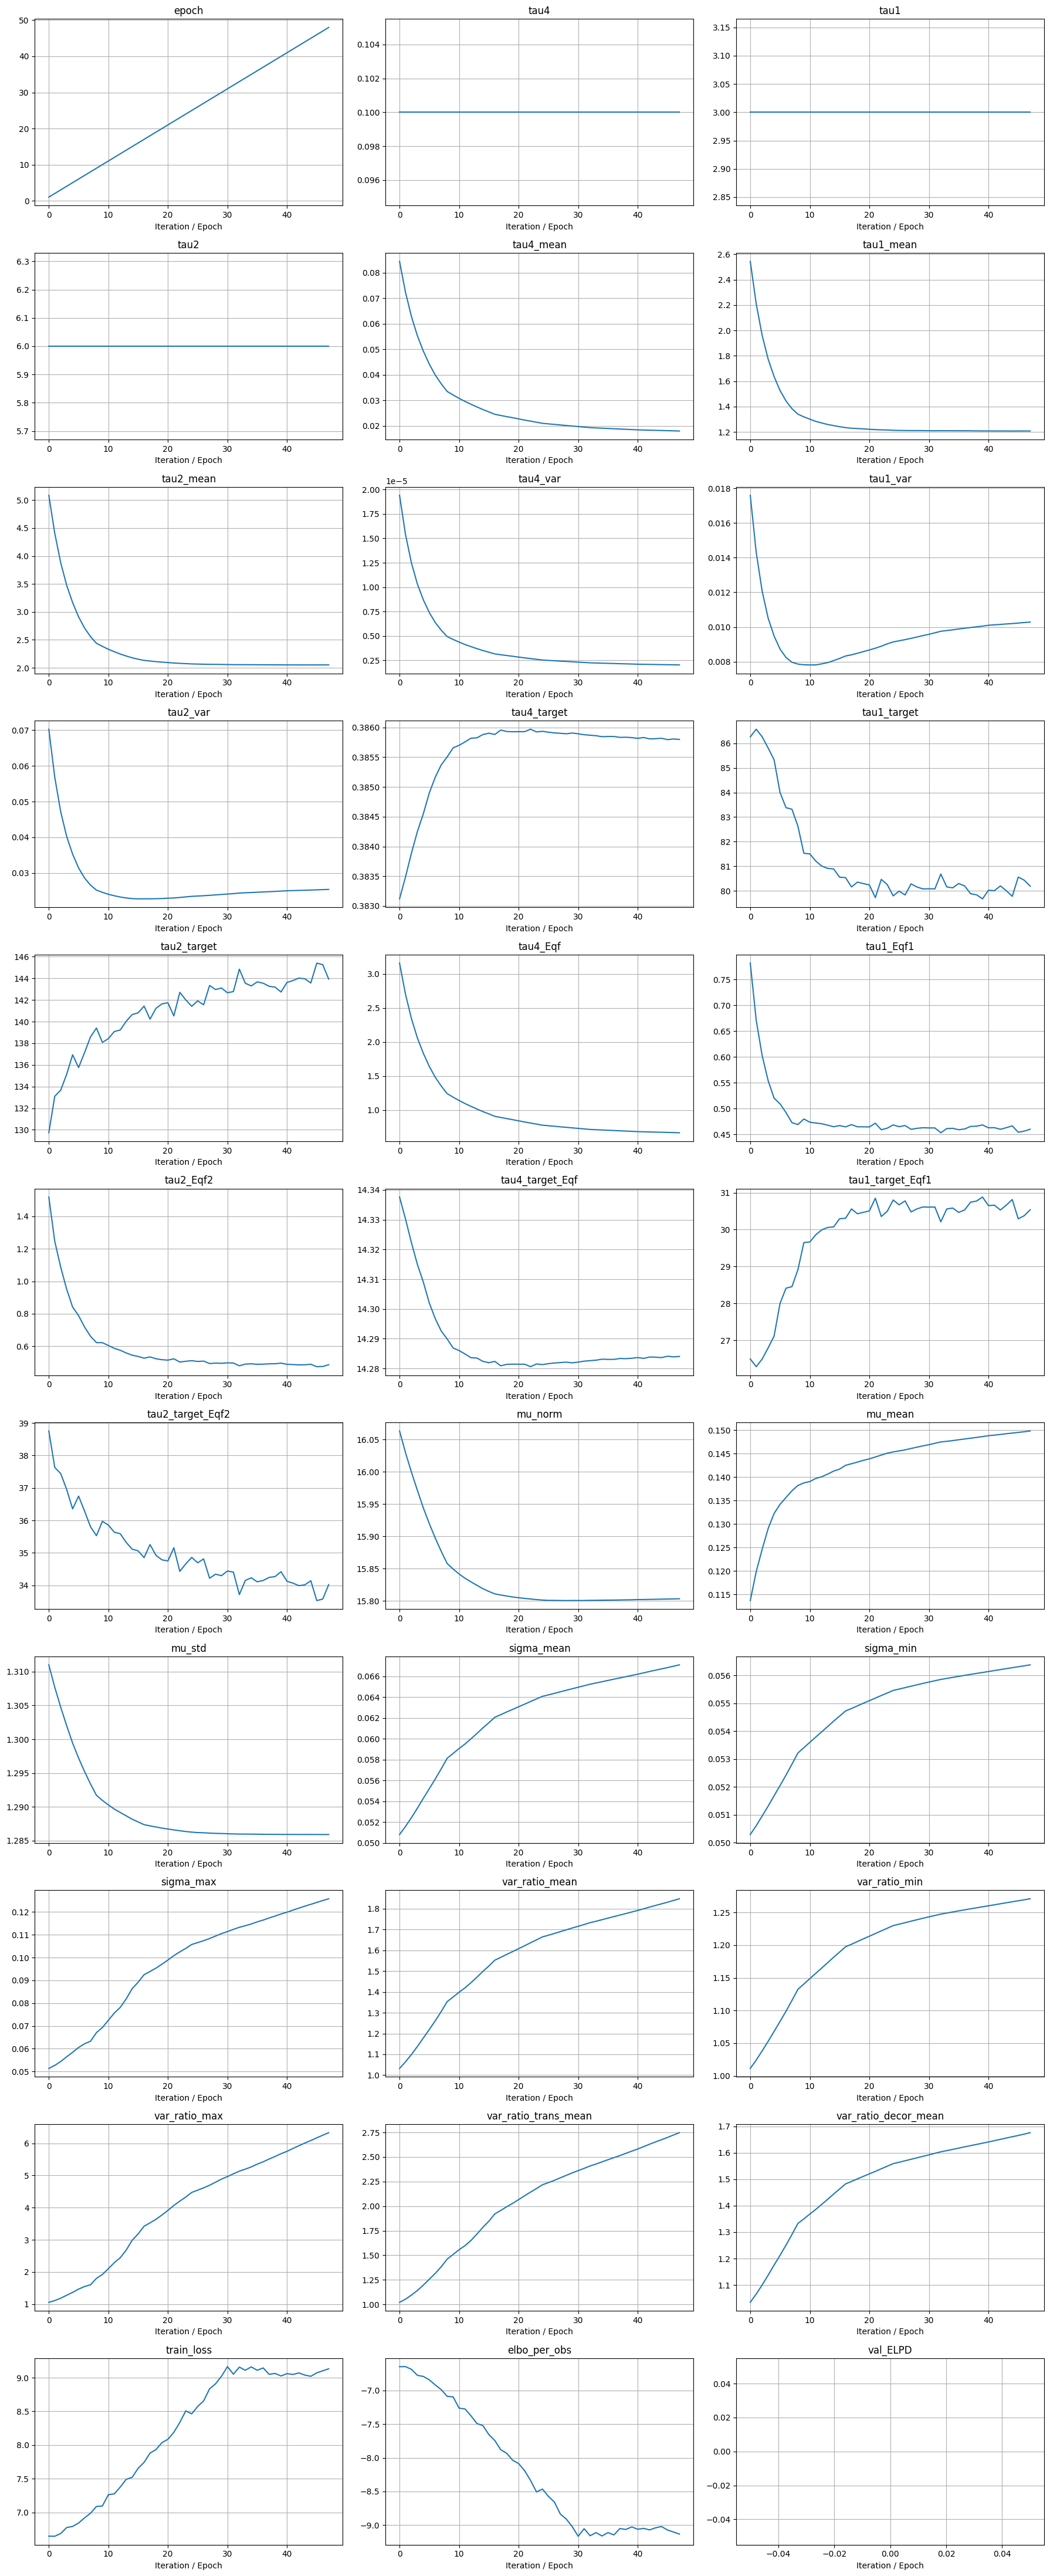

In [26]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [27]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



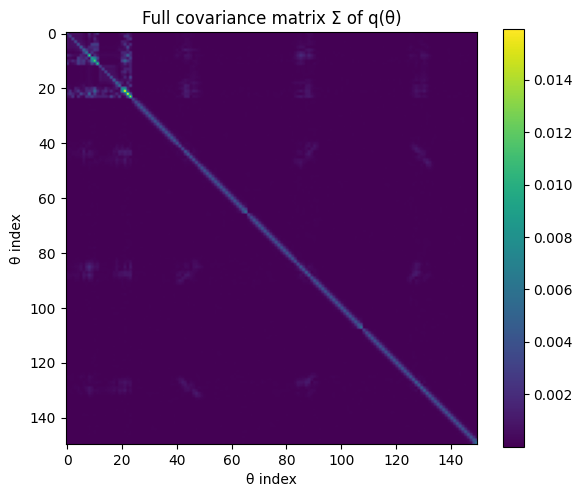

In [28]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


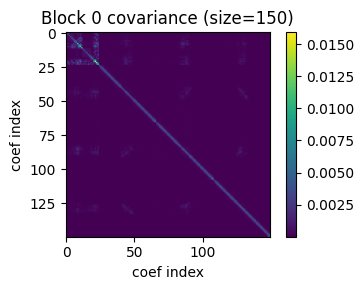

In [29]:
def plot_blocks_covariance(VI):
    import matplotlib.pyplot as plt

    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [30]:
import torch
import math
from torch.nn.utils.stateless import _reparametrize_module

def sample_bayesian_predictive(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    n_samples: int,
    S: int = 32,
    decor_present: bool = True,
):
    """
    Draw samples from the Bayesian predictive:
        p(y) ≈ (1/S) ∑_s p(y | θ_s, τ_s)
    by:
      - sampling θ_s ~ q(θ)
      - sampling τ_s ~ q(τ) (if tau_nodes is not None)
      - for each s, drawing n_samples/S from model with those parameters
    """
    device = model.device
    S = min(S, n_samples)
    n_per = math.ceil(n_samples / S)

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    # sample taus for each s (or fall back to hyperparameters)
    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    samples_all = []

    for s in range(S):
        theta_s = theta_samples[s]

        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            # if your sample() does not take taus, you can instead
            # stash them into model.hyperparameter[...] before calling sample
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            y_s = model.sample(n_per)  # shape [n_per, d]
            samples_all.append(y_s)

    y_cat = torch.cat(samples_all, dim=0)
    return y_cat[:n_samples]


def log_prob_bayesian_mixture(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    y: torch.Tensor, # [N, d]
    S: int = 32,
    decor_present: bool = True,
):
    """
    Compute log p(y) under the Bayesian predictive via log-mean-exp over θ, τ.
    """
    device = model.device
    N = y.shape[0]

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    logps = []

    for s in range(S):
        theta_s = theta_samples[s]
        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            # adapt this to your GTM's density API
            # e.g. if you have model.log_prob(y):
            ll_s = model.log_likelihood(y)     # [N]
            logps.append(ll_s)

    logps = torch.stack(logps, dim=0)   # [S, N]

    # log mean exp over S
    m, _ = torch.max(logps, dim=0, keepdim=True)
    log_mean = m.squeeze(0) + torch.log(torch.mean(torch.exp(logps - m), dim=0))  # [N]

    return log_mean  # [N]


In [31]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

log_likelihood_train_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_train,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_validate_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_validate,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_test_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_test,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [32]:
@torch.no_grad()
def sanity_check_covariance(VI):
    L_blocks = VI._build_L_blocks()

    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        print(f"\n[Block {b}] size={idx.numel()}")

        # shape
        print("  L.shape =", tuple(L.shape))

        # lower-triangular check
        upper = L.triu(diagonal=1)
        print("  max upper =", upper.abs().max().item())

        # diag positive?
        diag = torch.diag(L)
        print("  diag min =", diag.min().item(),
              "diag max =", diag.max().item())

        # positive definite?
        Sigma = L @ L.T
        eigvals = torch.linalg.eigvalsh(Sigma)
        print("  λ_min =", eigvals.min().item(),
              "λ_max =", eigvals.max().item(),
              "cond =", eigvals.max().item() / eigvals.min().item())

sanity_check_covariance(output["vi_model"])



[Block 0] size=150
  L.shape = (150, 150)
  max upper = 0.0
  diag min = 0.05636541545391083 diag max = 0.05640382319688797
  λ_min = 1.188081023428822e-05 λ_max = 0.030631305649876595 cond = 2578.2168931100446


In [33]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [34]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.058
KLD GTM      Train Data:  0.0092
KLD Gaussian Train Data:  0.1076
KLD Copula   Train Data:  -0.0004

KLD BGTM      Test  Data:  0.0661
KLD GTM      Test  Data:  0.0144
KLD Gaussian Test  Data:  0.1047
KLD Copula   Test  Data:  0.0008


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [35]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = sample_bayesian_predictive(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    n_samples=10_000,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


In [36]:
D = VI.mu.numel()
print("D =", D)
print("num_diag =", VI.num_diag)
print("block_sizes =", VI.block_sizes)
print("L_unconstrained length =", VI.L_unconstrained.numel())

expected_tris = sum(k * (k + 1) // 2 for k in VI.block_sizes)
print("expected_tris =", expected_tris)


D = 150
num_diag = 0
block_sizes = [150]
L_unconstrained length = 11325
expected_tris = 11325


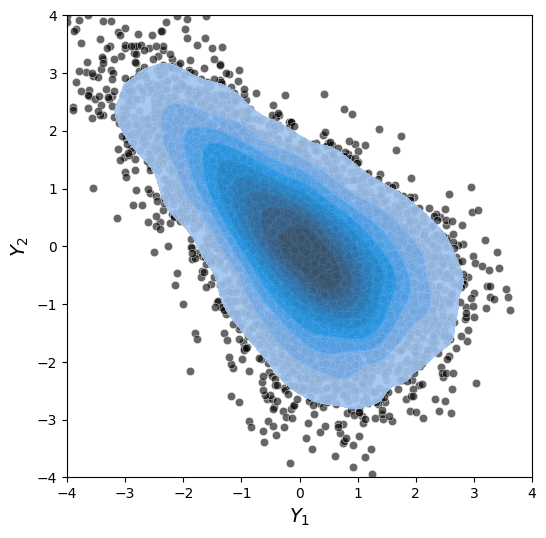

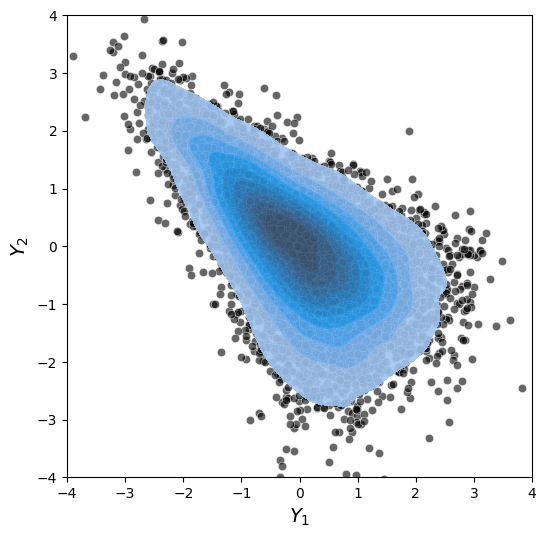

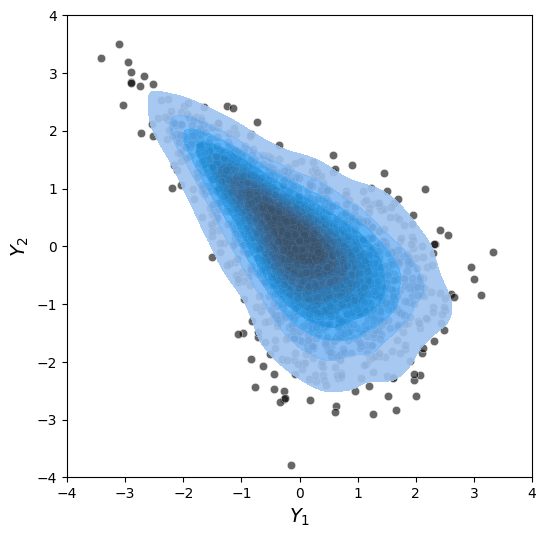

In [37]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [22]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [23]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


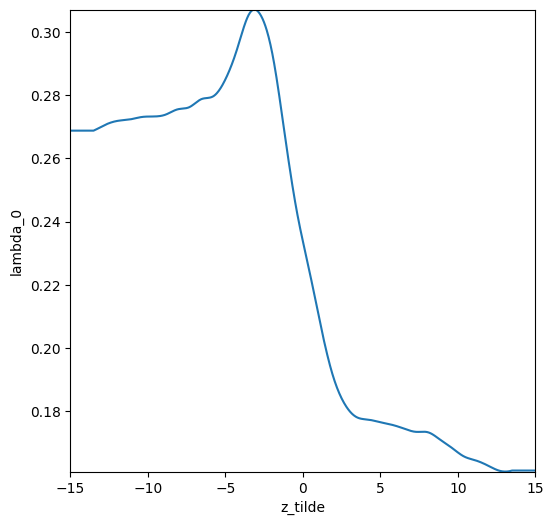

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


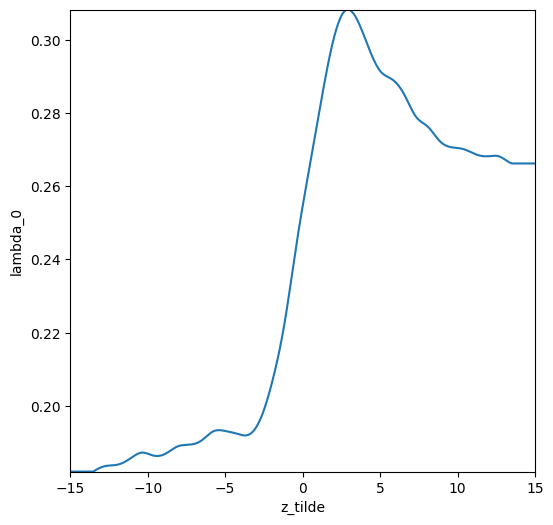

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


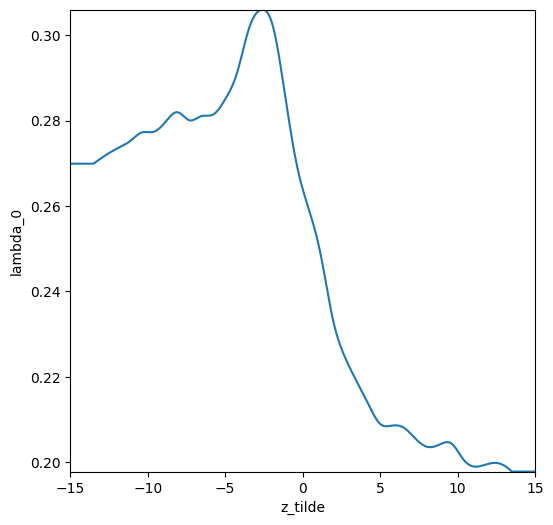

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)